# Measure Feature Map Similarity
This notebook is an enhanced version of a notebook in the Keras examples:
[Simple MNIST convnet](https://keras.io/examples/vision/mnist_convnet/)

Convolutional Neural Network (CNN) architectures use *feature maps* to capture aspects of an image. 

Since the set of feature maps is the complete inventory of features of an image found by a CNN, a well-trained model should not have redundant feature maps- the feature maps should all be different. This notebook introduces a measurement of similarity across feature maps with the aim of avoiding redundant feature maps.

We will train a simple CNN against the standard MNIST stroke-digit dataset and will demonstrate how the mean similarity of feature maps slowly drops during training. We will also display feature map activations against an original MNIST image to illuminate how feature map similarity is a good measurement of the quality of a CNN model.



In [1]:
import random
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!pip uninstall -y keras-wedge-dropout
!pip install -q git+https://github.com/LanceNorskog/keras-wedge.git
from keras_wedge_dropout import wedge_standardize1d

Found existing installation: keras-wedge-dropout 0.1.0
Uninstalling keras-wedge-dropout-0.1.0:
  Successfully uninstalled keras-wedge-dropout-0.1.0


In [3]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Build the model
The model in the original notebook is broken out into two models:

1.   a sub-model which emits the output of the CNN
2.   a parent model for training purposes

This allows us to extract feature maps and measure similarity in a callback function.

Remember, a Model is also a Layer. 

In [4]:
cnn_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    ]
    , name='CNN_sub_model'
)
cnn_model.summary()

model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        cnn_model,
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax"),
    ],
    name='Parent_model'
)

model.summary()

Model: "CNN_sub_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________
Model: "Parent_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_sub_model (Sequential)   (None, 11, 11, 64)        18816     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
___________________________

## Log image similarities during training

Add a Callback that fetches the final set of feature maps generated by the model, and calculates the average similarity of a random subset of pairs of feature maps.

There are various ways to calculate similarity. This multiplies the two feature maps together and counts the resulting "high" valued cells.

In [5]:
img_array = x_test[0:64]

# While training, capture and log the mean similarity of the feature map pairs.
# This network only has 64 fmaps, so it's ok to just check every pair.
# This is using when training the complete network, but calls predict()
# on the sub-network to fetch the feature maps.

class LogSimilarities(keras.callbacks.Callback):
    def __init__(self, cnn_model, img_array, simfunc, similarity=0.09):
        super(LogSimilarities, self).__init__()
        self._cnn_model = cnn_model
        self._img_array = img_array
        self._simfunc = simfunc
        self._similarity = similarity

    def on_epoch_end(self, epoch, logs=None):
        # an interesting number of predictions
        maps = self._cnn_model.predict(self._img_array)[:, :, :, :]
        # count of how many times an fmap is dinged for similarity
        fmaps = np.zeros((maps.shape[3],), dtype='int32')
        sims = []
        for k in range(maps.shape[0]):
            preds = []
            for i in range(maps.shape[3]):
                preds.append(maps[k, :, :, i])
            for i in range(maps.shape[3]):
                for j in range(i + 1, maps.shape[3]):
                    _, measure = self._simfunc(preds[i], preds[j])
                    sims.append(measure)
                    if measure > self._similarity:
                        fmaps[i] += 1
                        fmaps[j] += 1
        avg = sum(sims)/len(sims)
        if logs:
            if not 'similarity' in logs:
                logs['similarity'] = []
                logs['fmaps'] = []
            logs['similarity'].append(avg)
            logs['fmaps'].append(fmaps)
        else:
            print('Epoch: ' + epoch + ', mean similarity: ' + avg)


## Train the model

In [6]:
batch_size = 512
epochs = 100

simfunc = wedge_standardize1d
logsim = LogSimilarities(cnn_model, img_array, simfunc=simfunc)
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,
          callbacks=[logsim, early_stopping])

Epoch 1/100
106/106 [==============================] - 25s 225ms/step - loss: 0.6588 - accuracy: 0.8215 - val_loss: 0.1506 - val_accuracy: 0.9567
Epoch 2/100
106/106 [==============================] - 23s 221ms/step - loss: 0.1540 - accuracy: 0.9544 - val_loss: 0.0897 - val_accuracy: 0.9767
Epoch 3/100
106/106 [==============================] - 23s 220ms/step - loss: 0.1056 - accuracy: 0.9683 - val_loss: 0.0707 - val_accuracy: 0.9802
Epoch 4/100
106/106 [==============================] - 24s 224ms/step - loss: 0.0845 - accuracy: 0.9753 - val_loss: 0.0579 - val_accuracy: 0.9850
Epoch 5/100
106/106 [==============================] - 23s 220ms/step - loss: 0.0714 - accuracy: 0.9788 - val_loss: 0.0526 - val_accuracy: 0.9875
Epoch 6/100
106/106 [==============================] - 23s 221ms/step - loss: 0.0640 - accuracy: 0.9802 - val_loss: 0.0498 - val_accuracy: 0.9867
Epoch 7/100
106/106 [==============================] - 23s 221ms/step - loss: 0.0572 - accuracy: 0.9825 - val_loss: 0.0471 -

## Analyze Similarity of Feature Maps
In this section, we will do various images to help you understand feature maps and the similarity concept.

### Plot mean similarity over epochs

Let's plot the **similarity** value gathered during training. This is the mean similarity between all pairs of the 64 feature maps generated by the CNN network.

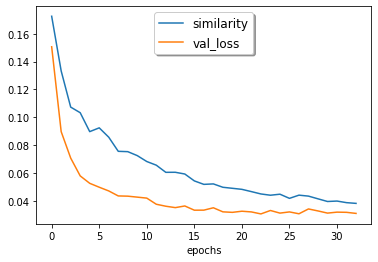

In [7]:
import matplotlib.pyplot as plt

def plot_similarity_stats(history):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(history['similarity'], label='similarity')
    ax.plot(history['val_loss'], label='val_loss')
    legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
    ax.set(xlabel='epochs', title='')

plot_similarity_stats(history.history)

This chart demonstrates how the drop in similarity tracks the improvement of the CNN (val_loss). CNN feature maps will slowly become decorrelated during a stable training cycle. Also notice how the similarity continues to drop as the network overtrains (val_loss starts increasing).

## Plot grid of feature maps violating similarity
Let's drill down with a more detailed measurement of feature map similarity.


In [ ]:
fig, ax = plt.subplots()
fmaps = np.squeeze(np.asarray(history.history['fmaps']))
print(fmaps.shape)
ax.set(xlabel='fmap set', ylabel='epochs')
_ = ax.imshow(fmaps, cmap='jet', origin='lower')



This chart shows all of the feature maps with a flag for whether or not they were 'too similar' to another feature map, per epoch. All feature maps are compared to each other. This plot counts the number of times an fmap is too similar to any other fmap, for 64 images.

Purple means "too similar". As you can see, the fmaps start out often being too similar to each other but slowly drift apart.

## Visualize the Feature Maps

First, we will create the feature maps for one image and calculate the similarity for all pairs of feature maps, keeping the image pairs with the maximum and minimum similarity.


In [9]:
!pip uninstall -y -qq keract
!pip install -qq git+https://github.com/LanceNorskog/keract.git

import keract  
del keract
import keract  
from sklearn.preprocessing import MinMaxScaler



Phillipe Remy's "Keract" library provides a very handy toolkit for fetching all of the feature maps generate for an image. It also will adorn the original image with data from a feature map to create a "heatmap", which superimposes the feature map onto the original image used to make the prediction. 

In [10]:
img_first = img_array[0]
maps = cnn_model.predict(img_array)[:, :, :, :]
maps_first = cnn_model.predict(img_array[0:1])[:, :, :, :]
preds = []
for i in range(maps.shape[3]):
    preds.append(maps[0, :, :, i])
preds = np.asarray(preds)
scaler = MinMaxScaler()
scaler.fit(preds.reshape(-1, 1))


sims = []
x = 0
min_i = -1
min_j = -1
max_i = -1
max_j = -1
min_sim = 100000
max_sim = -1

for i in range(len(preds)):
    for j in range(i + 1, len(preds)):
        _, measure = simfunc(preds[i], preds[j])
        top_i = np.max(preds[i])
        top_j = np.max(preds[j])
        ratio = np.max([top_i, top_j])/np.min([top_i, top_j])
        if measure < min_sim and ratio < 3:
            min_sim = measure
            min_i = i
            min_j = j
        if measure > max_sim:
            max_sim = measure
            max_i = i
            max_j = j
        sims.append(measure)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in float_scalars


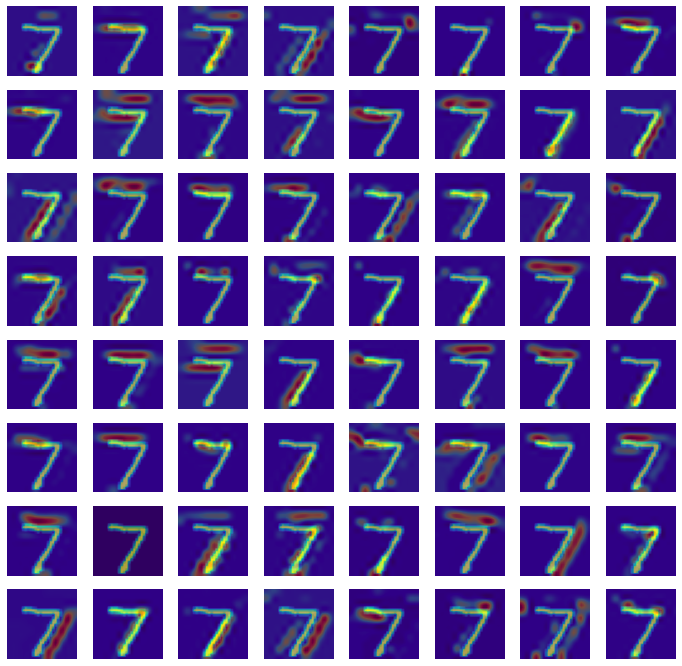

In [11]:
activations = {'': maps_first}
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
axes[3][2].grid(color='r', linestyle='-', linewidth=2)
keract.display_heatmaps_1(activations, img_first, in_fig=fig, in_axes=axes)

These 64 heatmaps are "features" or "aspects" of what the CNN notices about the handwritten digit '7'. There are several different measurements of horizontal and diagonal strokes. This does not show all possible feature maps that the CNN model can generate, it only shows the maps which are activated by this image.

Note:
> These images are a great demonstration of the "translation invariance" property of Convolutional Neural Networks. As the image is processed by a stack of Conv2D layers, activations "slide across" the image. Different input images with the same features in different places in the image can activate the same feature map. This is why a feature map might "light up" next to the handwritten stroke rather than on it: the handwritten digits are all roughly the same size, but they are placed differently inside the image. The feature maps pick an "average" placement for a horizontal or diagonal stroke.



### Similar Feature Maps
Next we will display the most similar pair of feature maps above, and then multiply the two feature maps together in Hadamard (cell-wise) mode to demonstrate their correlation. The left and middle images are the two feature maps, the rightmost image is the two feature maps multiplied together. The red sections in the right-most image are the similar sections of the two feature maps. One measure of "similarity" is to count the number of "hot" pixels that are above the mean of the image.

In [12]:
def plot_heatmaps(img_array, fmap_i, fmap_j, similarity=None):
    sim_label = ''
    if similarity:
        sim_label = "{:.2f}".format(similarity)
    feature_maps = np.zeros((1, fmap_i.shape[0], fmap_i.shape[1], 3), dtype='float32')
    feature_maps[0, :, :, 0] = fmap_i
    feature_maps[0, :, :, 1] = fmap_j
    feature_maps[0, :, :, 2] = fmap_i[:,:] * fmap_j[:,:]
    activations = {sim_label: feature_maps}
    fig, axes = plt.subplots(1, 3, figsize=(12, 12))
    keract.display_heatmaps_1(activations, img_array, in_fig=fig, in_axes=axes, title=False)

In [19]:
import matplotlib.gridspec as gridspec

def plot_heatmaps_gridspec(img_array, fmap_i, fmap_j, similarity=None):
    fig = plt.figure(tight_layout=True)
    gs = gridspec.GridSpec(2, 3)
    ax = fig.add_subplot(gs[:, 1:3])
    keract.display_heatmap(fmap_i[:,:] * fmap_j[:,:], img_array, fig, ax, cmap='jet')
    ax.set_title('common areas')
    for i, fmap in enumerate([fmap_i, fmap_j]):
        ax = fig.add_subplot(gs[i, 0])
        if i == 0:
                ax.set_title('originals')
        keract.display_heatmap(fmap, img_array, fig, ax, cmap='jet')

    plt.show()
    plt.close()

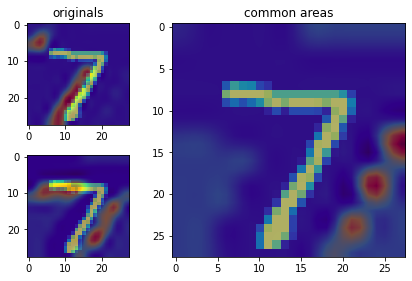

In [20]:
plot_heatmaps_gridspec(img_first, np.squeeze(preds[max_i]), np.squeeze(preds[max_j]))


The left and middle images are the two feature maps, the rightmost image is the two feature maps multiplied together. The red sections in the right-most image are the similar sections of the two feature maps. One measure of "similarity" is to count the number of "hot" pixels that are above the mean of the image.

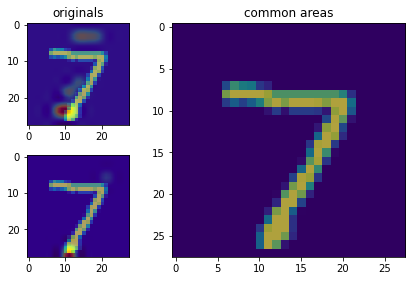

In [21]:
plot_heatmaps_gridspec(img_first, np.squeeze(preds[min_i]), np.squeeze(preds[min_j]))


Here we do the same with the least similar feature maps. Since they have no common areas, there no activated areas on the right. 

(The rightmost image has a slightly darker background because high and low activations are exaggerated by multiplying.)

## Conclusion


It is clear from this demonstration that feature map similarity is a valid indicator of the **predictive power** of a convolutional neural network: as the network improves, the mean similarity will drop. 

The reason for this is simple: good feature maps are decorrelated. Feature maps should be *independent captures* of *image features* (parts of images that happen over and over in the input images). If multiple feature maps describe the same feature, then processing power is being wasted. (Notice that in the grid of feature maps above, there are many duplicates of the diagonal and horizontal strokes.) The **descriptive power** of the feature maps is improved when no two feature maps describe the same feature. Optimizing the descriptive power of features maps will increase the predictive power of the model.

Building on this insight, it should be possible to improve a convolutional model by measuring feature map similarity and providing feedback via the loss function. This is the core idea behind Wedge Dropout.